In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import joblib
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/data_wind.csv')

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# csv_file = 'Featured_Database.csv' # CHANGE THIS to your actual filename
MODEL_SAVE_PATH = "day_ahead_model_wind.pth"
SCALER_PATH = "day_ahead_scaler_wind.gz"
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

In [6]:
df

,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,Wind_production
0,2019-01-01-T00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0.465992
1,2019-01-01-T00:05,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0.474615
2,2019-01-01-T00:10,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0.483570
3,2019-01-01-T00:15,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0.484233
4,2019-01-01-T00:20,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0.481248
...,...,...,...,...,...,...,...,...,...,...
315643,2021-12-31-T23:35,4,4,0.0,0.0,0.0,1.64,64.898,5.68,0.626518
315644,2021-12-31-T23:40,4,4,0.0,0.0,0.0,1.64,64.970,5.66,0.622704
315645,2021-12-31-T23:45,4,4,0.0,0.0,0.0,1.64,65.042,5.64,0.622041
315646,2021-12-31-T23:50,4,4,0.0,0.0,0.0,1.64,65.234,5.60,0.629006


In [7]:

df["season_sin"] = np.sin(2 * np.pi * df["Season"] / 4)
df["season_cos"] = np.cos(2 * np.pi * df["Season"] / 4)
df["weekday_sin"] = np.sin(2 * np.pi * df["Day_of_the_week"] / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df["Day_of_the_week"] / 7)
# # df["PV_potential"] = df["GHI"]*df["Temperature"]
# df.drop(columns=['Season','Day_of_the_week'],inplace=True)
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')
# df['GHI_diff_5m'] = df['GHI'].diff(periods=1)
# df['GHI_rolling_std_30m'] = df['GHI'].rolling(window=6).std()
# df['hour_min'] = df['Time'].dt.strftime('%H:%M')
# clear_sky_proxy = df.groupby('hour_min')['GHI'].transform('max')
# df['Clearness_Index'] = df['GHI'] / (clear_sky_proxy + 1e-9) # Avoid div by zero
df.dropna(inplace=True)
#
# df['target'] = df['PV_production']

df['Wind_production'] = df['Wind_production'].clip(0,1)


In [8]:
df

,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,Wind_production,season_sin,season_cos,weekday_sin,weekday_cos
0,2019-01-01 00:00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0.465992,1.000000e+00,6.123234e-17,0.781831,0.623490
1,2019-01-01 00:05:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0.474615,1.000000e+00,6.123234e-17,0.781831,0.623490
2,2019-01-01 00:10:00,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0.483570,1.000000e+00,6.123234e-17,0.781831,0.623490
3,2019-01-01 00:15:00,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0.484233,1.000000e+00,6.123234e-17,0.781831,0.623490
4,2019-01-01 00:20:00,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0.481248,1.000000e+00,6.123234e-17,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315643,2021-12-31 23:35:00,4,4,0.0,0.0,0.0,1.64,64.898,5.68,0.626518,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315644,2021-12-31 23:40:00,4,4,0.0,0.0,0.0,1.64,64.970,5.66,0.622704,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315645,2021-12-31 23:45:00,4,4,0.0,0.0,0.0,1.64,65.042,5.64,0.622041,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315646,2021-12-31 23:50:00,4,4,0.0,0.0,0.0,1.64,65.234,5.60,0.629006,-2.449294e-16,1.000000e+00,-0.433884,-0.900969


In [9]:
df.drop(columns=['GHI','DNI','DHI'],inplace=True)

In [10]:
df

,Time,Season,Day_of_the_week,Wind_speed,Humidity,Temperature,Wind_production,season_sin,season_cos,weekday_sin,weekday_cos
0,2019-01-01 00:00:00,1,1,2.88,56.036,1.82,0.465992,1.000000e+00,6.123234e-17,0.781831,0.623490
1,2019-01-01 00:05:00,1,1,2.88,56.036,1.82,0.474615,1.000000e+00,6.123234e-17,0.781831,0.623490
2,2019-01-01 00:10:00,1,1,2.88,56.194,1.78,0.483570,1.000000e+00,6.123234e-17,0.781831,0.623490
3,2019-01-01 00:15:00,1,1,2.88,56.344,1.74,0.484233,1.000000e+00,6.123234e-17,0.781831,0.623490
4,2019-01-01 00:20:00,1,1,2.84,56.440,1.72,0.481248,1.000000e+00,6.123234e-17,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...
315643,2021-12-31 23:35:00,4,4,1.64,64.898,5.68,0.626518,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315644,2021-12-31 23:40:00,4,4,1.64,64.970,5.66,0.622704,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315645,2021-12-31 23:45:00,4,4,1.64,65.042,5.64,0.622041,-2.449294e-16,1.000000e+00,-0.433884,-0.900969
315646,2021-12-31 23:50:00,4,4,1.64,65.234,5.60,0.629006,-2.449294e-16,1.000000e+00,-0.433884,-0.900969


In [11]:
# 1. Reload the data to reset the dataframe (Fixes the "Already Indexed" bug)


# 2. Strip any hidden whitespace from column names (Fixes " Time" vs "Time")
df.columns = df.columns.str.strip()

# 3. Check if 'Time' is a column before processing
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
else:
    print("⚠️ 'Time' column not found. It might already be the index.")

# 4. Verify


In [12]:
df_hourly = df.resample('1h').mean()
df_hourly.dropna(inplace=True)


In [13]:
len(df_hourly)



26304

In [14]:
feature_cols = [ 'Wind_speed', 'Humidity', 'Temperature',
                'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos','Wind_production'
                ]


# 1. Fit and Transform ONLY the features you want to normalize
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hourly[feature_cols])

# 2. Create the DataFrame with just the scaled columns first
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols, index=df_hourly.index)

# 3. Add the 'Wind_production' column directly from the original df (Unscaled)
# df_scaled['Wind_production'] = df_hourly['Wind_production']

# Now df_scaled contains normalized features + raw Wind_production
print(df_scaled.head())

# Save scaler (It only knows about the weather/time columns, which is correct)
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to {SCALER_PATH}")



future_driver_cols = ['Temperature', 'Wind_speed', 'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos']

# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_hourly[feature_cols]),
#                          columns=feature_cols, index=df_hourly.index)

# # Save scaler for inference
# joblib.dump(scaler, SCALER_PATH)
# print(f"Scaler saved to {SCALER_PATH}")


                     Wind_speed  Humidity  Temperature  season_sin  \
Time                                                                 
2019-01-01 00:00:00    0.276158  0.575774     0.054707         1.0   
2019-01-01 01:00:00    0.267367  0.567291     0.047641         1.0   
2019-01-01 02:00:00    0.257075  0.559124     0.042099         1.0   
2019-01-01 03:00:00    0.252573  0.556320     0.036979         1.0   
2019-01-01 04:00:00    0.249142  0.556044     0.032579         1.0   

                     season_cos  weekday_sin  weekday_cos  Wind_production  
Time                                                                        
2019-01-01 00:00:00         0.5     0.900969     0.801938         0.493788  
2019-01-01 01:00:00         0.5     0.900969     0.801938         0.438900  
2019-01-01 02:00:00         0.5     0.900969     0.801938         0.419160  
2019-01-01 03:00:00         0.5     0.900969     0.801938         0.416044  
2019-01-01 04:00:00         0.5     0.900969   

In [15]:
df_scaled

,Wind_speed,Humidity,Temperature,season_sin,season_cos,weekday_sin,weekday_cos,Wind_production
Time,,,,,,,,
2019-01-01 00:00:00,0.276158,0.575774,0.054707,1.0,0.5,0.900969,0.801938,0.493788
2019-01-01 01:00:00,0.267367,0.567291,0.047641,1.0,0.5,0.900969,0.801938,0.438900
2019-01-01 02:00:00,0.257075,0.559124,0.042099,1.0,0.5,0.900969,0.801938,0.419160
2019-01-01 03:00:00,0.252573,0.556320,0.036979,1.0,0.5,0.900969,0.801938,0.416044
2019-01-01 04:00:00,0.249142,0.556044,0.032579,1.0,0.5,0.900969,0.801938,0.407922
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.132075,0.692864,0.191961,0.5,1.0,0.277479,0.000000,0.604121
2021-12-31 20:00:00,0.124357,0.696927,0.183372,0.5,1.0,0.277479,0.000000,0.605613
2021-12-31 21:00:00,0.124786,0.699764,0.174572,0.5,1.0,0.277479,0.000000,0.645049


In [18]:
def create_day_ahead_sequences(data, feature_cols, future_cols, lookback=24, horizon=24):
    X_past, X_future, y = [], [], []

    # We need to ensure we have enough data for past AND future
    # Loop from 'lookback' until 'len - horizon'
    for i in range(lookback, len(data) - horizon):
        # 1. Past Data (t-24 to t)
        past_slice = data.iloc[i-lookback : i][feature_cols].values

        # 2. Future Weather (t to t+24)
        # Note: In real training, we use actual future weather as a proxy for the forecast
        future_slice = data.iloc[i : i+horizon][future_cols].values

        # 3. Target (t to t+24)
        target_slice = data.iloc[i : i+horizon]['Wind_production'].values

        X_past.append(past_slice)
        X_future.append(future_slice)
        y.append(target_slice)

    return np.array(X_past), np.array(X_future), np.array(y)

print("Creating Sequences...")
X_past, X_future, y = create_day_ahead_sequences(df_scaled, feature_cols, future_driver_cols)

Creating Sequences...


In [19]:
split = int(len(X_past) * 0.9)
X_past_train, X_future_train, y_train = X_past[:split], X_future[:split], y[:split]
X_past_test, X_future_test, y_test = X_past[split:], X_future[split:], y[split:]

In [20]:
class SolarDayAheadDataset(Dataset):
    def __init__(self, x_past, x_future, y):
        self.x_past = torch.tensor(x_past, dtype=torch.float32)
        self.x_future = torch.tensor(x_future, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_past[idx], self.x_future[idx], self.y[idx]

train_loader = DataLoader(SolarDayAheadDataset(X_past_train, X_future_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SolarDayAheadDataset(X_past_test, X_future_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

In [21]:
class DayAheadNet(nn.Module):
    def __init__(self, past_features, future_features, hidden_size=64):
        super(DayAheadNet, self).__init__()

        # Encoder (Processes Past History)
        self.lstm = nn.LSTM(input_size=past_features, hidden_size=hidden_size, batch_first=True)

        # Processor (Processes Future Weather)
        # We flatten the 24h future weather: 24 * num_future_features
        self.future_fc = nn.Linear(24 * future_features, hidden_size)

        # Combiner
        self.combine_fc = nn.Linear(hidden_size + hidden_size, hidden_size)

        # Decoder (Output 24 hours of generation)
        self.output_fc = nn.Linear(hidden_size, 24)
        self.sigmoid = nn.Sigmoid() # Force 0-1 range

    def forward(self, past, future):
        # past: (Batch, 24, past_features)
        # future: (Batch, 24, future_features)

        # 1. Encode Past
        _, (hidden, _) = self.lstm(past)
        context = hidden[-1] # (Batch, hidden_size)

        # 2. Process Future
        # Flatten future: (Batch, 24*future_features)
        future_flat = future.reshape(future.shape[0], -1)
        future_context = torch.relu(self.future_fc(future_flat))

        # 3. Combine
        combined = torch.cat((context, future_context), dim=1)
        combined = torch.relu(self.combine_fc(combined))

        # 4. Predict
        out = self.output_fc(combined)
        return self.sigmoid(out)

In [22]:
model = DayAheadNet(past_features=len(feature_cols), future_features=len(future_driver_cols)).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 5. TRAINING LOOP ---
print(f"Starting Training on {DEVICE}...")
best_loss = float('inf')

Starting Training on cuda...


In [23]:
from sklearn.metrics import r2_score
from tqdm import tqdm

# --- 5. TRAINING LOOP WITH TQDM & R2 SCORE ---
print(f"Starting Training on {DEVICE}...")

# Track the best R2 score (Initialize to -infinity)
best_val_r2 = -float('inf')

for epoch in range(EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0

    # Wrap train_loader with tqdm for the progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for past_b, future_b, y_b in loop:
        past_b, future_b, y_b = past_b.to(DEVICE), future_b.to(DEVICE), y_b.to(DEVICE)

        optimizer.zero_grad()
        preds = model(past_b, future_b)
        loss = criterion(preds, y_b)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Update progress bar with current batch loss
        loop.set_postfix(loss=f"{loss.item():.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for past_b, future_b, y_b in test_loader:
            past_b, future_b, y_b = past_b.to(DEVICE), future_b.to(DEVICE), y_b.to(DEVICE)

            preds = model(past_b, future_b)
            loss = criterion(preds, y_b)
            val_loss += loss.item()

            # Store for R2 calculation (Move to CPU numpy)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_b.cpu().numpy())

    # Concatenate all batches for full epoch metrics
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Calculate R2 Score (Flatten the 24h outputs into one long vector)
    val_r2 = r2_score(all_targets.flatten(), all_preds.flatten())
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    # Print clean summary
    print(f"Epoch {epoch+1} | Train MSE: {avg_train_loss:.5f} | Val MSE: {avg_val_loss:.5f} | Val R2: {val_r2:.4f}")

    # --- SAVE MODEL IF R2 IMPROVES ---
    if val_r2 > best_val_r2:
        print(f"🔥 R2 improved from {best_val_r2:.4f} to {val_r2:.4f}. Saving model...")
        best_val_r2 = val_r2
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"\nTraining Complete. Best R2 Score: {best_val_r2:.4f}")

Starting Training on cuda...


Epoch 1 | Train MSE: 0.04150 | Val MSE: 0.03120 | Val R2: 0.3421
🔥 R2 improved from -inf to 0.3421. Saving model...


Epoch 2 | Train MSE: 0.02697 | Val MSE: 0.02557 | Val R2: 0.4699
🔥 R2 improved from 0.3421 to 0.4699. Saving model...


Epoch 3 | Train MSE: 0.02174 | Val MSE: 0.02272 | Val R2: 0.5344
🔥 R2 improved from 0.4699 to 0.5344. Saving model...


Epoch 4 | Train MSE: 0.02018 | Val MSE: 0.02191 | Val R2: 0.5513
🔥 R2 improved from 0.5344 to 0.5513. Saving model...


Epoch 5 | Train MSE: 0.01933 | Val MSE: 0.02138 | Val R2: 0.5621
🔥 R2 improved from 0.5513 to 0.5621. Saving model...


Epoch 6 | Train MSE: 0.01876 | Val MSE: 0.02072 | Val R2: 0.5761
🔥 R2 improved from 0.5621 to 0.5761. Saving model...


Epoch 7 | Train MSE: 0.01834 | Val MSE: 0.02052 | Val R2: 0.5812
🔥 R2 improved from 0.5761 to 0.5812. Saving model...


Epoch 8 | Train MSE: 0.01796 | Val MSE: 0.02029 | Val R2: 0.5865
🔥 R2 improved from 0.5812 to 0.5865. Saving model...


Epoch 9 | Train MSE: 0.01767 | Val MSE: 0.02068 | Val R2: 0.5789


Epoch 10 | Train MSE: 0.01743 | Val MSE: 0.02080 | Val R2: 0.5772


Epoch 11 | Train MSE: 0.01718 | Val MSE: 0.02181 | Val R2: 0.5557


Epoch 12 | Train MSE: 0.01705 | Val MSE: 0.02142 | Val R2: 0.5645


Epoch 13 | Train MSE: 0.01688 | Val MSE: 0.02159 | Val R2: 0.5613


Epoch 14 | Train MSE: 0.01671 | Val MSE: 0.02118 | Val R2: 0.5691


Epoch 15 | Train MSE: 0.01660 | Val MSE: 0.02092 | Val R2: 0.5742


Epoch 16 | Train MSE: 0.01650 | Val MSE: 0.02080 | Val R2: 0.5755


Epoch 17 | Train MSE: 0.01637 | Val MSE: 0.02085 | Val R2: 0.5738


Epoch 18 | Train MSE: 0.01624 | Val MSE: 0.02033 | Val R2: 0.5844


Epoch 19 | Train MSE: 0.01618 | Val MSE: 0.02093 | Val R2: 0.5722


Epoch 20 | Train MSE: 0.01606 | Val MSE: 0.02038 | Val R2: 0.5827


Epoch 21 | Train MSE: 0.01595 | Val MSE: 0.02070 | Val R2: 0.5763


Epoch 22 | Train MSE: 0.01585 | Val MSE: 0.02048 | Val R2: 0.5801


Epoch 23 | Train MSE: 0.01575 | Val MSE: 0.02053 | Val R2: 0.5791


Epoch 24 | Train MSE: 0.01564 | Val MSE: 0.02055 | Val R2: 0.5791


Epoch 25 | Train MSE: 0.01554 | Val MSE: 0.02042 | Val R2: 0.5821


Epoch 26 | Train MSE: 0.01544 | Val MSE: 0.02027 | Val R2: 0.5858


Epoch 27 | Train MSE: 0.01532 | Val MSE: 0.02014 | Val R2: 0.5885
🔥 R2 improved from 0.5865 to 0.5885. Saving model...


Epoch 28 | Train MSE: 0.01519 | Val MSE: 0.02017 | Val R2: 0.5887
🔥 R2 improved from 0.5885 to 0.5887. Saving model...


Epoch 29 | Train MSE: 0.01511 | Val MSE: 0.02066 | Val R2: 0.5795


Epoch 30 | Train MSE: 0.01495 | Val MSE: 0.02110 | Val R2: 0.5711


Epoch 31 | Train MSE: 0.01490 | Val MSE: 0.02197 | Val R2: 0.5540


Epoch 32 | Train MSE: 0.01486 | Val MSE: 0.02236 | Val R2: 0.5455


Epoch 33 | Train MSE: 0.01475 | Val MSE: 0.02203 | Val R2: 0.5515


Epoch 34 | Train MSE: 0.01477 | Val MSE: 0.02187 | Val R2: 0.5497


Epoch 35 | Train MSE: 0.01452 | Val MSE: 0.02134 | Val R2: 0.5570


Epoch 36 | Train MSE: 0.01442 | Val MSE: 0.02208 | Val R2: 0.5454


Epoch 37 | Train MSE: 0.01435 | Val MSE: 0.02158 | Val R2: 0.5524


Epoch 38 | Train MSE: 0.01423 | Val MSE: 0.02180 | Val R2: 0.5459


Epoch 39 | Train MSE: 0.01445 | Val MSE: 0.02124 | Val R2: 0.5593


Epoch 40 | Train MSE: 0.01418 | Val MSE: 0.02166 | Val R2: 0.5521


Epoch 41 | Train MSE: 0.01415 | Val MSE: 0.02131 | Val R2: 0.5582


Epoch 42 | Train MSE: 0.01394 | Val MSE: 0.02110 | Val R2: 0.5624


Epoch 43 | Train MSE: 0.01388 | Val MSE: 0.02058 | Val R2: 0.5644


Epoch 44 | Train MSE: 0.01391 | Val MSE: 0.02134 | Val R2: 0.5535


Epoch 45 | Train MSE: 0.01373 | Val MSE: 0.02123 | Val R2: 0.5521


Epoch 46 | Train MSE: 0.01407 | Val MSE: 0.01996 | Val R2: 0.5865


Epoch 47 | Train MSE: 0.01372 | Val MSE: 0.02147 | Val R2: 0.5488


Epoch 48 | Train MSE: 0.01357 | Val MSE: 0.02215 | Val R2: 0.5359


Epoch 49 | Train MSE: 0.01343 | Val MSE: 0.02191 | Val R2: 0.5456


Epoch 50 | Train MSE: 0.01318 | Val MSE: 0.02333 | Val R2: 0.5186


Epoch 51 | Train MSE: 0.01298 | Val MSE: 0.02319 | Val R2: 0.5123


Epoch 52 | Train MSE: 0.01286 | Val MSE: 0.02371 | Val R2: 0.5036


Epoch 53 | Train MSE: 0.01291 | Val MSE: 0.02345 | Val R2: 0.5163


Epoch 54 | Train MSE: 0.01292 | Val MSE: 0.02540 | Val R2: 0.4791


Epoch 55 | Train MSE: 0.01275 | Val MSE: 0.02438 | Val R2: 0.4947


Epoch 56 | Train MSE: 0.01238 | Val MSE: 0.02322 | Val R2: 0.5192


Epoch 57 | Train MSE: 0.01219 | Val MSE: 0.02545 | Val R2: 0.4741


Epoch 58 | Train MSE: 0.01215 | Val MSE: 0.02607 | Val R2: 0.4633


Epoch 59 | Train MSE: 0.01196 | Val MSE: 0.02337 | Val R2: 0.5178


Epoch 60 | Train MSE: 0.01208 | Val MSE: 0.02290 | Val R2: 0.5276


Epoch 61 | Train MSE: 0.01208 | Val MSE: 0.02224 | Val R2: 0.5434


Epoch 62 | Train MSE: 0.01177 | Val MSE: 0.02190 | Val R2: 0.5492


Epoch 63 | Train MSE: 0.01169 | Val MSE: 0.02099 | Val R2: 0.5704


Epoch 64 | Train MSE: 0.01160 | Val MSE: 0.02071 | Val R2: 0.5769


Epoch 65 | Train MSE: 0.01142 | Val MSE: 0.02147 | Val R2: 0.5642


Epoch 66 | Train MSE: 0.01161 | Val MSE: 0.02036 | Val R2: 0.5836


Epoch 67 | Train MSE: 0.01160 | Val MSE: 0.02326 | Val R2: 0.5346


Epoch 68 | Train MSE: 0.01131 | Val MSE: 0.02205 | Val R2: 0.5532


Epoch 69 | Train MSE: 0.01122 | Val MSE: 0.02353 | Val R2: 0.5246


Epoch 70 | Train MSE: 0.01118 | Val MSE: 0.02351 | Val R2: 0.5208


Epoch 71 | Train MSE: 0.01111 | Val MSE: 0.02308 | Val R2: 0.5312


Epoch 72 | Train MSE: 0.01097 | Val MSE: 0.02279 | Val R2: 0.5347


Epoch 73 | Train MSE: 0.01087 | Val MSE: 0.02202 | Val R2: 0.5479


Epoch 74 | Train MSE: 0.01109 | Val MSE: 0.02235 | Val R2: 0.5412


Epoch 75 | Train MSE: 0.01082 | Val MSE: 0.02169 | Val R2: 0.5582


Epoch 76 | Train MSE: 0.01068 | Val MSE: 0.02297 | Val R2: 0.5354


Epoch 77 | Train MSE: 0.01054 | Val MSE: 0.02345 | Val R2: 0.5214


Epoch 78 | Train MSE: 0.01015 | Val MSE: 0.02140 | Val R2: 0.5631


Epoch 79 | Train MSE: 0.01003 | Val MSE: 0.02354 | Val R2: 0.5220


Epoch 80 | Train MSE: 0.01045 | Val MSE: 0.02594 | Val R2: 0.4691


Epoch 81 | Train MSE: 0.01028 | Val MSE: 0.02392 | Val R2: 0.5141


Epoch 82 | Train MSE: 0.00973 | Val MSE: 0.02041 | Val R2: 0.5740


Epoch 83 | Train MSE: 0.00957 | Val MSE: 0.02208 | Val R2: 0.5451


Epoch 84 | Train MSE: 0.00990 | Val MSE: 0.02316 | Val R2: 0.5285


Epoch 85 | Train MSE: 0.00965 | Val MSE: 0.02123 | Val R2: 0.5581


Epoch 86 | Train MSE: 0.00963 | Val MSE: 0.02077 | Val R2: 0.5691


Epoch 87 | Train MSE: 0.00981 | Val MSE: 0.02492 | Val R2: 0.4956


Epoch 88 | Train MSE: 0.00962 | Val MSE: 0.02447 | Val R2: 0.5069


Epoch 89 | Train MSE: 0.00932 | Val MSE: 0.02407 | Val R2: 0.5033


Epoch 90 | Train MSE: 0.00943 | Val MSE: 0.02479 | Val R2: 0.4838


Epoch 91 | Train MSE: 0.00906 | Val MSE: 0.02365 | Val R2: 0.5078


Epoch 92 | Train MSE: 0.00894 | Val MSE: 0.02597 | Val R2: 0.4778


Epoch 93 | Train MSE: 0.00867 | Val MSE: 0.02495 | Val R2: 0.4830


Epoch 94 | Train MSE: 0.00871 | Val MSE: 0.02573 | Val R2: 0.4880


Epoch 95 | Train MSE: 0.00864 | Val MSE: 0.02507 | Val R2: 0.4855


Epoch 96 | Train MSE: 0.00867 | Val MSE: 0.02655 | Val R2: 0.4462


Epoch 97 | Train MSE: 0.00850 | Val MSE: 0.02503 | Val R2: 0.4681


Epoch 98 | Train MSE: 0.00856 | Val MSE: 0.02356 | Val R2: 0.5170


Epoch 99 | Train MSE: 0.00847 | Val MSE: 0.02461 | Val R2: 0.4949


Epoch 100 | Train MSE: 0.00875 | Val MSE: 0.02593 | Val R2: 0.4593

Training Complete. Best R2 Score: 0.5887


✅ Model loaded. Preparing simulation...
🔮 Predicting Day-Ahead Generation...
📈 Upscaling to 5-minute resolution...


/tmp/ipython-input-984192320.py:67: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mock_data = pd.DataFrame(index=pd.date_range("2022-01-01 00:00", periods=48, freq='1H'))


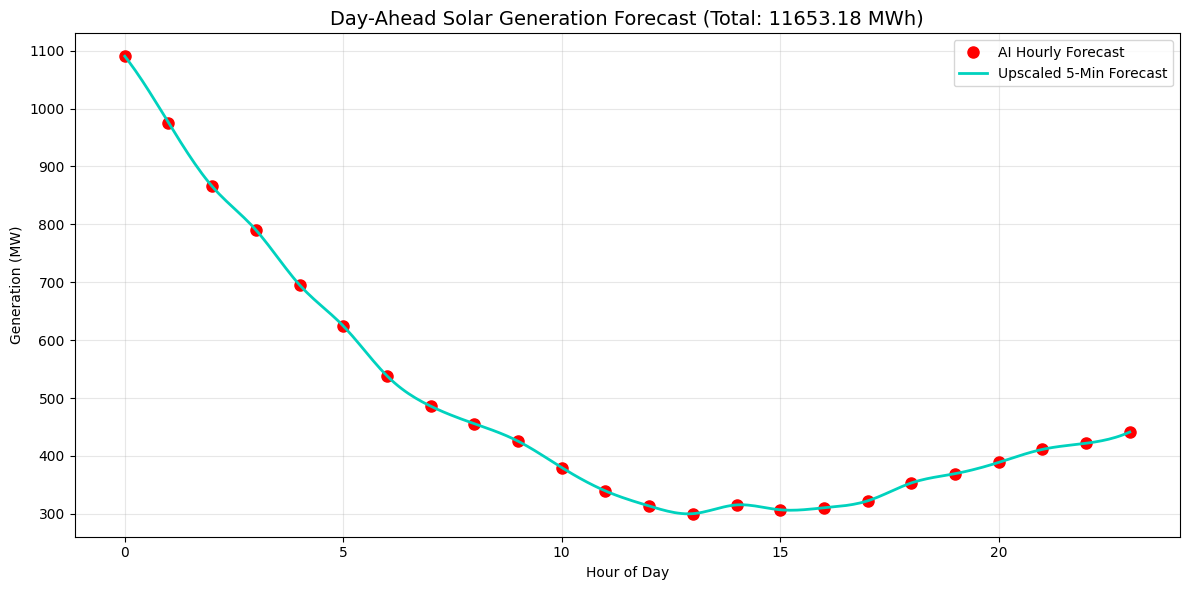

Done! Displaying graph.


In [25]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/day_ahead_model_wind.pth"
SCALER_PATH = "/content/day_ahead_scaler_wind.gz"
MAX_CAPACITY = 3000 # MW

# Columns MUST match training
# feature_cols = ['DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature',
#                 'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos',
#                 'PV_potential', 'GHI_diff_5m', 'GHI_rolling_std_30m', 'Clearness_Index', 'target']
# future_driver_cols = ['GHI', 'Temperature', 'Wind_speed', 'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos']

feature_cols = [ 'Wind_speed', 'Humidity', 'Temperature',
                'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos','Wind_production'
                ]

future_driver_cols = ['Temperature', 'Wind_speed', 'season_sin', 'season_cos', 'weekday_sin', 'weekday_cos']

# --- 1. DEFINE MODEL ARCHITECTURE (Same as training) ---
class DayAheadNet(nn.Module):
    def __init__(self, past_features, future_features, hidden_size=64):
        super(DayAheadNet, self).__init__()
        self.lstm = nn.LSTM(input_size=past_features, hidden_size=hidden_size, batch_first=True)
        self.future_fc = nn.Linear(24 * future_features, hidden_size)
        self.combine_fc = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.output_fc = nn.Linear(hidden_size, 24)
        self.sigmoid = nn.Sigmoid()

    def forward(self, past, future):
        _, (hidden, _) = self.lstm(past)
        context = hidden[-1]
        future_flat = future.reshape(future.shape[0], -1)
        future_context = torch.relu(self.future_fc(future_flat))
        combined = torch.cat((context, future_context), dim=1)
        combined = torch.relu(self.combine_fc(combined))
        return self.sigmoid(self.output_fc(combined))

# --- 2. LOAD RESOURCES ---
scaler = joblib.load(SCALER_PATH)
model = DayAheadNet(past_features=len(feature_cols), future_features=len(future_driver_cols)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("✅ Model loaded. Preparing simulation...")

# --- 3. SIMULATE INPUT DATA (Mocking the DB) ---
# In a real scenario, you fetch this from your DB/CSV
# We need:
# A. Past 24 hours of REAL data (Context)
# B. Next 24 hours of FORECAST weather (Oracle)

# Let's generate dummy data that looks realistic (Sine waves for sun)
# Creating 48 hours of dummy weather
hours = np.arange(48)
# dummy_ghi = np.clip(np.sin((hours - 6) * np.pi / 12), 0, 1) # Sun up 6am-6pm
# dummy_temp = 20 + 10 * np.sin((hours - 9) * np.pi / 12) + np.random.normal(0, 1, 48)

# Construct DataFrame
mock_data = pd.DataFrame(index=pd.date_range("2022-01-01 00:00", periods=48, freq='1H'))
for col in feature_cols:
    mock_data[col] = 0.5 # Default fill

# mock_data['GHI'] = dummy_ghi
# mock_data['Temperature'] = dummy_temp
# mock_data['target'] = dummy_ghi * 0.8 # Assume simplified efficiency

# Scale the data using the SAME scaler
mock_scaled = pd.DataFrame(scaler.transform(mock_data), columns=feature_cols, index=mock_data.index)

# Prepare Tensors
# Past: First 24 hours (Index 0 to 24)
past_input = mock_scaled.iloc[0:24][feature_cols].values
past_tensor = torch.tensor(past_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

# Future: Next 24 hours (Index 24 to 48) - ONLY WEATHER COLS
future_input = mock_scaled.iloc[24:48][future_driver_cols].values
future_tensor = torch.tensor(future_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

# --- 4. PREDICT ---
print("🔮 Predicting Day-Ahead Generation...")
with torch.no_grad():
    prediction_24h_norm = model(past_tensor, future_tensor).cpu().numpy().flatten()

# Denormalize (Convert 0-1 back to MW)
prediction_24h_mw = prediction_24h_norm * MAX_CAPACITY

# --- 5. UPSCALE TO 5-MINUTE INTERVALS ---
print("📈 Upscaling to 5-minute resolution...")

# Original Time points (Hours 0, 1, 2... 23)
x_hours = np.arange(24)
# Target Time points (0.0, 0.083, 0.166... 23.91) -> 288 points
x_5min = np.linspace(0, 23, 24 * 12)

# Cubic Interpolation for smoothness
f = interp1d(x_hours, prediction_24h_mw, kind='cubic')
prediction_5min_mw = f(x_5min)
# Clip negatives (cubic spline can dip below 0 slightly)
prediction_5min_mw = np.clip(prediction_5min_mw, 0, None)

# --- 6. PLOT ---
plt.figure(figsize=(12, 6))

# Plot 1: The Hourly 'Anchor' Points
plt.plot(x_hours, prediction_24h_mw, 'o', color='red', label='AI Hourly Forecast', markersize=8)

# Plot 2: The Smooth 5-Min Curve
plt.plot(x_5min, prediction_5min_mw, '-', color='#00d2be', linewidth=2, label='Upscaled 5-Min Forecast')

plt.title(f"Day-Ahead Solar Generation Forecast (Total: {prediction_5min_mw.sum()/12:.2f} MWh)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Generation (MW)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Done! Displaying graph.")